## CS 110 Final Project - Saad Bin Ihsan ##

### First implementation of the hash table and plagiarism detection mechanism ###

Problem statement - 
- Store all length-k substrings of X into a hash table TX with the hash values computed by using rolling hashing.
- For each substring sy n Y, compute the hash value h(sy) using rolling hashing, and use this hash value to look up sy in table TX. If the lookup is successful, then we have a common substring.



#### Methodology used ####

1. Firstly, for any inputs that we will be getting for the algorithm, we can parse the data first and clean it up by removing any special characters and removing the difference between capital and lowercase letters since the only aspect we're interested in is being able to find the parts of the two strings that match within the context of the english alphabet since we're operating under the assumption that we'll only be using the algorithm with english papers.

    To do so, the following preprocessing code was prepared using code that we were provided in the earlier Trie trees assignment for cleaning up the online shakespearean inputs.

    The runtime of this preprocessing is O(length of the text) since the code runs through each and every character within the inputted string to format it accordingly. However, within the context of the overall algorithm, since this will only be done once in the beginning while preparing the strings to be checked, we can assume a cost of O(1) (constant) since we're not going to be doing it multiple times for a single input.

In [39]:
def preprocessing(text):
    '''
    Preprocessing text to only work with the lowercase english alphabet since we're only focusing
    on textual plagiarism. Functionality has been reused from the code that was provided in the Trie
    assignment with cleaning up the input.
    
    Inputs:
    
    text(string) - Unprocessed string
    
    Outputs:
    
    str - processed string without any special characters and everything being in lower case
    '''
    
    text = text.lower()
    bad_chars = [';', ',', '.', '?', '!', '_', '[', ']', ':', '“', '”', '"', '–', '-', ' ']
    just_text = ''.join(c for c in text if c not in bad_chars)
    without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " " for c in just_text)
    just_words = [word for word in without_newlines.split(" ") if word != ""]
    
    if len(just_words) == 0:
        return ''
    
    return just_words[0]

In [2]:
#Demonstrating functionality

string = 'CS110: Problem-solving with Algorithms and Datastructures'
assert(preprocessing(string) == 'cs110problemsolvingwithalgorithmsanddatastructures')

2. After preprocessing the inputs to the algorithm, I decided to implement the hashing part of the algorithm and find the hashes for example cases to see whether the implementation works.

    This was done by creating an initial_hash function which adds the integer value of each character (found through the ord functionality in python) from left to right and as it is adding, multiplies the corresponding value with the base the hash is being calculated in. This can be seen with how, to create the hash for 'abcd' if they corresponded to [1,2,3,4] respectively within the denary would be done by the following algorithmic procedure
    
    a = 1 
    
    ab = 1*10 + 2
    
    abc = 12*10 + 3
    
    abcd = 123*10 + 4
    
    
    Alongside, for the rolling hashing functionality, this was done using the algorithm given within the readings for the assignment.

In [3]:
def initial_hash(string,d,q):
    '''
    Function which calculates the initial hash value for a string.
    
    Inputs:
    string(string) - what we need to find the hash for
    d(int) - base of calculations
    q(int) - size of hash table'''
    
    value = 0
    for i in string:
        value = value * d + ord(i)
    return value % q

def rolling_hash(initial_string_hash,initial_string, new_character, d, q):
    '''
    Function which calculates the new hash for a string with one character added and the first
    character deleted in a rolling manner.
    
    Inputs:
    Initial_string_hash(int) - The hash being used to compute the new hash
    initial_string(string) - The string to which the character is being added
    new_character (string of length 1) - The character which is being added to the string
    d(int) = the base of calculations
    q(int) = size of the hash table
    '''
    
    adding_char_to_right = (initial_string_hash*d + ord(new_character)) % q
    deleting_char_from_left = (adding_char_to_right - ord(initial_string[0])*d**(len(initial_string)) %q)%q
    
    
    return deleting_char_from_left % q
    

To prove it's functionality, I used the example given within the readings by looking at the hash value calculated through rolling hashing for the string 'tod' to which the character 'a' is added and directly comparing it with the value we obtain by calculating the hash of the rolled string 'oda' directly and as the assertion statement shows, it works within this case.

The running time of the initial hash function is O(length of the string). Since in this case, the length of the string will remain constant, this will be constant time O(1). On the other hand, the rolling_hash function will be dependent of the number of k-length substrings within the string itself which would be equal to O(length of entire string - k) where k is the length of the substrings being looked at when calcualting the rolling hashes for the entire string being looked at. Since each of these operations is mainly a menial calculation within the context of computational power required, this will not contribute much to the actual running time of the algorithm, since we can assume the constant multiplier with the time complexity to be low.


In [4]:
assert(rolling_hash(initial_hash('tod',7,10),'tod','a',7,10) == initial_hash('oda',7,10))

3. After going through the functionality of the hashing functions, it was now time to create the respective hash tables that would be used to store all the substrings within their corresponding hash values. I decided to do this within the context of Object oriented programming by creating a Hash table object that iteratively implements the hashing and creation of the table functionality with respect to the inputted string.

In [95]:
class Hash_table_rolling:
    '''
    The rolling hash table object that utilizes functionality within OOT to optimize the creation of the hash table
    alongside finding hashes for strings.
    
    Parameters:
    base(int) - The mathematical base for computation (This was chosen to be 26 to represent the number of characters
    within the english alphabet)
    capacity(int) - The total carrying capacity of the hash table with how many unique hashes it contains
    
    Functions:
    __init__(constructor for the object): Creates the required object using the words and the k-length for the substrings
    being looked at
    
    roll (Rolling hashing implementation within the object): Moves the current window being looked at and updates the 
    hash value through rolling accordingly
    
    current_string (string representation of the current window (current k-length substring))
    
    set_up_table (Hash table contruction with k-length substrings throughout the current string)
    
    plagiarism_checker (returns tuples of where the substrings for two strings match)
    
    '''
    base = 26
    capacity = 100

    def __init__(self, text, k):
        '''
        
        Constructor function for the Hash_table_rolling object
        
        Inputs:
        
        text(string) - The text being used as a base to create the hash table
        k(integer) - Length of the substrings being analyzed within the string
        
        Parameters:
        
        table(list of lists) - Represents the corresponding hash table being used to store the values
        text(string) - The entire string being analyzed
        k_size(int) - Placeholder for k
        hash(int) - The hash value associated with the current k-length substring within the text being analyzed
        window_start(int) - the starting index of the current k-length substring
        window_end(int) - the ending index of the current k-length substring
        plagiarised_indices(list) - the indices from the comparison string which have been plagiarised
        '''
        self.table = [[] for i in range(self.capacity)]
        self.text = text
        if len(text) < k:
            self.hash = None
            return
        
        #calculating the hash value for the first k-length substring
        hash_calc = 0
        for c in text[:k]:
            hash_calc = hash_calc * self.base + ord(c)
        self.k_size = k
        self.hash = hash_calc % self.capacity
        self.window_start = 0
        self.window_end = k
        self.plagiarised_indices = []
        self.collisions = 0

    def roll(self):
        '''Implements the rolling hashing functionality by calculating the new hash value using the old hash value by
        using the algorithm described within the readings for the assignment. Updates window_start and window_end
        accordingly to signify the change in the current substring       
        '''
        if self.window_end < len(self.text):
            self.hash = (self.hash*self.base + ord(self.text[self.window_end])) % self.capacity
            self.hash = (self.hash - ord(self.text[self.window_start])*self.base**(len(self.text))%self.capacity)%self.capacity        
#             self.hash = ((self.hash - (ord(self.text[self.window_start])) * self.multiplier) \
#                 * Hash_table_rolling.base \
#                 + ord(self.text[self.window_end])) % self.capacity
            self.window_start += 1
            self.window_end += 1

    def current_string(self):
        '''
        Returns the string representation of the current k-length substring being looked at 
        
        '''
        return self.text[self.window_start:self.window_end]
    
    def set_up_table(self):
        '''
        Setting up the hash table by iteratively performing hashing on all k-length substrings and storing them alongside
        their position in a tuple within their hashed indices in the hash table. Furthermore, collisions are accounted for
        by creating lists at each index of the hash table where the substrings with the same indices are appended onto 
        that list
        
        Returns:
        collisions(int) - Calculating the number of dissimilar strings that ended up with the same hash value within the
        hash table to show the number of collisions that occur
        
        '''
        
        collisions = 0
        
        for i in range(len(self.text) - self.k_size + 1):
            if self.table[self.hash] is []:
                self.table[self.hash].append((self.current_string(),self.window_start))
            else:
                for i,ele in enumerate(self.table[self.hash]):
                    #Checking for collisions
                    if self.current_string() != ele[0]:
                        collisions +=1
                self.table[self.hash].append((self.current_string(),self.window_start))
            #Rolling on to the next substring
            self.roll()
        self.collisions = collisions
        print(f'Number of collisions = {collisions}')
        
    def return_collisions(self):
        return self.collisions
        
    def plagiarism_checker(self,other):
        '''
        Function which compares how much of the current string's k-length substrings are common with the k-length 
        substrings within another string
        
        Inputs:
        
        other (Hash_table_rolling object) - The hash object created from the other string being compared with
        
        Outputs:
        
        list of tuples: The first part of the tuple represents the ith substring which is the same as the jth substring
        of the second string in the second part of the tuple
        
        '''
        plagiarized_parts = []
        
        for i in range(len(self.text) - self.k_size + 1):
            
            if other.table[self.hash] is not None:
                for i in range(len(other.table[self.hash])):
                    if other.table[self.hash][i][0] == self.current_string():
                        plagiarized_parts.append((other.table[self.hash][i][1],self.window_start))
                        current_indices = list(range(other.table[self.hash][i][1],other.table[self.hash][i][1]+3))
                        self.plagiarised_indices+=current_indices
            self.roll()
        return plagiarized_parts
    
    def amount_of_plagiarism(self,other):
        '''
        Function which prints the amount of plagiarism calculated by taking the set of all plagiarised indices within
        the comparison string and finding the proportion with respect to the entire string.
        
        Inputs:
        
        other (Hash_table_rolling object) - The hash object created from the other string being compared with
        '''
        
        plagiarised_indices = set(self.plagiarised_indices)
        
        print(f'The amount of plagiarism is {(len(plagiarised_indices)/(len(other.text)+1))*100} percent') 

For the relative time complexities of each functions within the Object we have:

O(k) where k is the length of the substrings being analyzed for the construction of the object (__init__) since the only looping functionality is over the amount of characters in the beginnning of the string equating to the length of the substrings being analyzed

O(1) for the roll function since each roll does a single consistent calculation at each roll which does not depend on the size of the input

O(1) for the current_string representation

O(n-k)\*(Average load size of each hash) where n is the length of the entire string and k is the length of the substrings being analysed. Here (n-k) represents the number of times the loop will run since any string only has (n-k) of contigous k length substrings and since, here, we're only analysing consecutive characters (contiguity), this would mean that we don't have to account for cases with spaced out letters. Furthermore, this gets multiplied by the average load size since that will be the number of times we expect to loop over each hash while checking for an input.

O(1) for the amount_of_plagiarism function since it calculates using a defined set of arithmetical procedures that do not depend on the length of the input.

4. After creating the functionality using OOP, I transferred the code on to the base that we needed to code over for testing below

In [29]:
def rh_get_match(x, y, k):
    """
    Finds all common length-k substrings of x and y
    using rolling hashing on both strings.
    
    Input: 
        - x, y: strings
        - k: int, length of substring
        
    Output:
        - A list of tuples (i,j) where x[i:i+k] = y[j:j+k]
    """
    x = preprocessing(x)
    y = preprocessing(y)
    
    a = Hash_table_rolling(x,k)
    b = Hash_table_rolling(y,k)
    a.set_up_table()
    
    if x == "" or y == "":
        return None
    
    plagiarised_tuples = b.plagiarism_checker(a)
    b.amount_of_plagiarism(a)
    return plagiarised_tuples

In [30]:
#Testing for the base case provided in the example
rh_get_match('Today is monday!', 'day', 3)

Number of collisions = 0
The amount of plagiarism is 42.857142857142854 percent


[(2, 0), (10, 0)]

In [35]:
#Testing for two long string repeated with repeated substrings 'ab' which are exactly the same
text1 = 'ab'*20
text2 = 'ab'*20
rh_get_match(text1,text2,2)

Number of collisions = 0
The amount of plagiarism is 100.0 percent


[(0, 0),
 (2, 0),
 (4, 0),
 (6, 0),
 (8, 0),
 (10, 0),
 (12, 0),
 (14, 0),
 (16, 0),
 (18, 0),
 (20, 0),
 (22, 0),
 (24, 0),
 (26, 0),
 (28, 0),
 (30, 0),
 (32, 0),
 (34, 0),
 (36, 0),
 (38, 0),
 (1, 1),
 (3, 1),
 (5, 1),
 (7, 1),
 (9, 1),
 (11, 1),
 (13, 1),
 (15, 1),
 (17, 1),
 (19, 1),
 (21, 1),
 (23, 1),
 (25, 1),
 (27, 1),
 (29, 1),
 (31, 1),
 (33, 1),
 (35, 1),
 (37, 1),
 (0, 2),
 (2, 2),
 (4, 2),
 (6, 2),
 (8, 2),
 (10, 2),
 (12, 2),
 (14, 2),
 (16, 2),
 (18, 2),
 (20, 2),
 (22, 2),
 (24, 2),
 (26, 2),
 (28, 2),
 (30, 2),
 (32, 2),
 (34, 2),
 (36, 2),
 (38, 2),
 (1, 3),
 (3, 3),
 (5, 3),
 (7, 3),
 (9, 3),
 (11, 3),
 (13, 3),
 (15, 3),
 (17, 3),
 (19, 3),
 (21, 3),
 (23, 3),
 (25, 3),
 (27, 3),
 (29, 3),
 (31, 3),
 (33, 3),
 (35, 3),
 (37, 3),
 (0, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (8, 4),
 (10, 4),
 (12, 4),
 (14, 4),
 (16, 4),
 (18, 4),
 (20, 4),
 (22, 4),
 (24, 4),
 (26, 4),
 (28, 4),
 (30, 4),
 (32, 4),
 (34, 4),
 (36, 4),
 (38, 4),
 (1, 5),
 (3, 5),
 (5, 5),
 (7, 5),
 (9, 5),


In [43]:
#Testing for empty strings which won't give an output
text1 = ''
text2 = ''
rh_get_match(text1,text2,0)

Number of collisions = 0


In [51]:
#Testing for examples of plagiarism given in https://examples.yourdictionary.com/examples-of-plagiarism.html

text1 = '''The legal system is made up of civil courts, criminal courts and specialty courts, such as family law courts and 
bankruptcy courts. Each court has its own jurisdiction, which refers to the cases that the court is allowed to hear. In some 
instances, a case can only be heard in one type of court. For example, a bankruptcy case must be heard in a bankruptcy court. 
In other instances, more than one court could potentially have jurisdiction. For example, a federal criminal court and a state 
criminal court would each have jurisdiction over a crime that is a federal drug offense but that is also a state offense.'''

text2 = '''The legal system is made up of criminal and civil courts and specialty courts like bankruptcy and family law courts. 
Each court is vested with its own jurisdiction. Jurisdiction refers to the types of cases the court is permitted to rule on. 
Sometimes, only one type of court can hear a particular case. For instance, bankruptcy cases can be ruled on only in bankruptcy 
court. In other situations, it is possible for more than one court to have jurisdiction. For instance, both a state and federal 
criminal court could have authority over a criminal case that is also considered an offense under federal and state drug laws.'''


rh_get_match(text1,text2,3)

Number of collisions = 39
The amount of plagiarism is 92.3913043478261 percent


[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (35, 24),
 (36, 25),
 (37, 26),
 (38, 27),
 (39, 28),
 (40, 29),
 (49, 32),
 (88, 32),
 (24, 35),
 (25, 36),
 (26, 37),
 (27, 38),
 (28, 39),
 (42, 39),
 (29, 40),
 (43, 40),
 (61, 40),
 (82, 40),
 (30, 41),
 (44, 41),
 (62, 41),
 (83, 41),
 (31, 42),
 (45, 42),
 (63, 42),
 (84, 42),
 (32, 43),
 (46, 43),
 (64, 43),
 (85, 43),
 (47, 44),
 (86, 44),
 (48, 45),
 (87, 45),
 (49, 46),
 (88, 46),
 (50, 47),
 (51, 48),
 (52, 49),
 (53, 50),
 (54, 51),
 (55, 52),
 (56, 53),
 (57, 54),
 (58, 55),
 (59, 56),
 (60, 57),
 (29, 58),
 (43, 58),
 (61, 58),
 (82, 58),
 (30, 59),
 (44, 59),
 (62, 59),
 (83, 59),
 (31, 60),
 (45, 60),
 (63, 60),
 (84, 60),
 (32, 61),
 (46, 61),
 (64, 61),
 (85, 61),
 (49, 78),
 (88, 78),
 (73, 81),
 (74, 82),
 (75, 83),
 (76, 84),
 (77, 85

### Second implementation of the hash table and plagiarism detection mechanism ###


Problem statement - Implement the same functionality without the division method


#### Methodology used ####

1. While looking at the division method, the main aspect that came with potential problems that came within real world analysis was the potential for collisions. Therefore, analysing a more general case, we can remove the limit for the capacity of the Hash table to look at a much more accurate implementation of the hashing. Furthermore, we can express this functionality within the context of the previous implementation by creating an extremely large hash_table and finding all the common substrings we can see within that table.

    Furthermore, here, since we won't be using rolling hashing, we will choose to individually calculate the hash values of each k-length substring and add that to the corresponding hash table position.

In [72]:
class Hash_table:
    '''
    The augmented Hash Table on the basis of the previous rolling example except without utilizing the division 
    functionality.
    
    Reusing most of the previous functionality, the only added method is
    
    calculate_hash - Calculates the hash value for the k-length substring from scratch
    
    '''
    base = 26
    capacity = 11881376

    def __init__(self, text, k):
        '''
        Reusing most of the 
        '''
        self.table = [[] for i in range(self.capacity)]
        self.text = text
        if len(text) < k:
            self.hash = None
            return

        self.k_size = k
        self.window_start = 0
        self.window_end = k
        self.plagiarised_indices = []
        self.hash = 0
        self.calculate_hash()

    def move(self):
        '''
        Moves to the next substring being looked at
        '''
        self.window_start += 1
        self.window_end += 1
    
    def calculate_hash(self):
        '''
        Calculates the hash value for each without modding for the capacity since we're looking at infinite capacity to store
        each substring separately.
        '''
        value = 0
        adjustment = ord('a') - 1
        
        for i in self.current_string():
            value = value * self.base + (ord(i) - adjustment)

        self.hash = value
        
    
    
    def current_string(self):
        '''
        Returns the string representation of the current k-length substring being looked at 
        
        '''
        return self.text[self.window_start:self.window_end]
    
    def set_up_table(self):
        '''
        Iteratively goes through all the k-length substrings within the string and adds them to their respective hash point
        in the table after which the substring is moved and the new hash value is calculated.
        
        '''
        for i in range(len(self.text) - self.k_size + 1):
            self.table[self.hash].append((self.current_string(),self.window_start))
            self.move()
            self.calculate_hash()
        
    def plagiarism_checker(self,other):
        '''
        Function which compares how much of the current string's k-length substrings are common with the k-length 
        substrings within another string
        
        Inputs:
        
        other (Hash_table object) - The hash object created from the other string being compared with
        
        Outputs:
        
        list of tuples: The first part of the tuple represents the ith substring which is the same as the jth substring
        of the second string in the second part of the tuple
        
        '''
        plagiarized_parts = []
        
        for i in range(len(self.text) - self.k_size + 1):
            
            if other.table[self.hash] is not None:
                for i in range(len(other.table[self.hash])):
                    plagiarized_parts.append((other.table[self.hash][i][1],self.window_start))
                    current_indices = list(range(other.table[self.hash][i][1],other.table[self.hash][i][1]+3))
                    self.plagiarised_indices+=current_indices       
            self.move()
            self.calculate_hash()
        return plagiarized_parts
    
    def amount_of_plagiarism(self,other):
        '''
        Function which prints the amount of plagiarism calculated by taking the set of all plagiarised indices within
        the comparison string and finding the proportion with respect to the entire string.
        
        Inputs:
        
        other (Hash_table object) - The hash object created from the other string being compared with
        '''
        
        plagiarised_indices = set(self.plagiarised_indices)
        
        print(f'The amount of plagiarism is {(len(plagiarised_indices)/(len(other.text)+1))*100} percent') 

With most of the methods being the same as before, the time complexity for them doesn't change except for the plagiarism checker since this function previously operated under the assumption that there could be collisions. However, in this case, that won't be possible.

In theory, this would mean that there is an average load factor of 0 since each unique substring has a unique point it can be put within. However, when we're looking within real-world conditions, this will not be representative since there isn't infinite memory to be able to store the substrings and thus, our hash values can only go up to the point encoded by the maximum number of spaces allowed by the computer.

This can easily be computed in theory by analysing the number of values that would need to be stored with the k-value of the substrings being looked at.

To store all the letters of substring length = 1, we would only need to store all the letters once which corresponds to 26

For length 2, we would need to store 26*26

This leads us to the equation where to store all k-length substrings in the alphabetical base, we would need 26^k number of spaces where k is the length of the substring.

In this case, since I want to look at a maximum of 5 letter matches, I set my capacity to be 26^5 = 11,881,376

This tells us that our space complexity would be exponential depending on the length of the substring being analysed.

In [73]:
def regular_get_match(x, y, k):
    """
    Finds all common length-k substrings of x and y
    NOT using rolling hashing on both strings.
    
    Input:
    - x, y: strings
    - k: int, length of substring
    
    Output:
    
    - A list of tuples (i, j)
    where x[i:i+k] = y[j:j+k]
    """
    x = preprocessing(x)
    y = preprocessing(y)
    
    a = Hash_table(x,k)
    b = Hash_table(y,k)
    a.set_up_table()
    
    if x == "" or y == "":
        return None
    
    plagiarised_tuples = b.plagiarism_checker(a)
    b.amount_of_plagiarism(a)
    return plagiarised_tuples

In [64]:
regular_get_match('Today is monday!', 'day', 3)

The amount of plagiarism is 42.857142857142854 percent


[(2, 0), (10, 0)]

In [65]:
#Testing for two long string repeated with repeated substrings 'ab' which are exactly the same
text1 = 'ab'*20
text2 = 'ab'*20
regular_get_match(text1,text2,2)

The amount of plagiarism is 100.0 percent


[(0, 0),
 (2, 0),
 (4, 0),
 (6, 0),
 (8, 0),
 (10, 0),
 (12, 0),
 (14, 0),
 (16, 0),
 (18, 0),
 (20, 0),
 (22, 0),
 (24, 0),
 (26, 0),
 (28, 0),
 (30, 0),
 (32, 0),
 (34, 0),
 (36, 0),
 (38, 0),
 (0, 1),
 (2, 1),
 (4, 1),
 (6, 1),
 (8, 1),
 (10, 1),
 (12, 1),
 (14, 1),
 (16, 1),
 (18, 1),
 (20, 1),
 (22, 1),
 (24, 1),
 (26, 1),
 (28, 1),
 (30, 1),
 (32, 1),
 (34, 1),
 (36, 1),
 (38, 1),
 (0, 2),
 (2, 2),
 (4, 2),
 (6, 2),
 (8, 2),
 (10, 2),
 (12, 2),
 (14, 2),
 (16, 2),
 (18, 2),
 (20, 2),
 (22, 2),
 (24, 2),
 (26, 2),
 (28, 2),
 (30, 2),
 (32, 2),
 (34, 2),
 (36, 2),
 (38, 2),
 (0, 3),
 (2, 3),
 (4, 3),
 (6, 3),
 (8, 3),
 (10, 3),
 (12, 3),
 (14, 3),
 (16, 3),
 (18, 3),
 (20, 3),
 (22, 3),
 (24, 3),
 (26, 3),
 (28, 3),
 (30, 3),
 (32, 3),
 (34, 3),
 (36, 3),
 (38, 3),
 (0, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (8, 4),
 (10, 4),
 (12, 4),
 (14, 4),
 (16, 4),
 (18, 4),
 (20, 4),
 (22, 4),
 (24, 4),
 (26, 4),
 (28, 4),
 (30, 4),
 (32, 4),
 (34, 4),
 (36, 4),
 (38, 4),
 (0, 5),
 (2, 5),
 (4, 5)

In [67]:
#Testing for empty strings which won't give an output
text1 = ''
text2 = ''
regular_get_match(text1,text2,0)

In [74]:
#Testing for examples of plagiarism given in https://examples.yourdictionary.com/examples-of-plagiarism.html

text1 = '''The legal system is made up of civil courts, criminal courts and specialty courts, such as family law courts and 
bankruptcy courts. Each court has its own jurisdiction, which refers to the cases that the court is allowed to hear. In some 
instances, a case can only be heard in one type of court. For example, a bankruptcy case must be heard in a bankruptcy court. 
In other instances, more than one court could potentially have jurisdiction. For example, a federal criminal court and a state 
criminal court would each have jurisdiction over a crime that is a federal drug offense but that is also a state offense.'''

text2 = '''The legal system is made up of criminal and civil courts and specialty courts like bankruptcy and family law courts. 
Each court is vested with its own jurisdiction. Jurisdiction refers to the types of cases the court is permitted to rule on. 
Sometimes, only one type of court can hear a particular case. For instance, bankruptcy cases can be ruled on only in bankruptcy 
court. In other situations, it is possible for more than one court to have jurisdiction. For instance, both a state and federal 
criminal court could have authority over a criminal case that is also considered an offense under federal and state drug laws.'''


regular_get_match(text1,text2,5)

The amount of plagiarism is 83.69565217391305 percent


[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (35, 24),
 (36, 25),
 (37, 26),
 (38, 27),
 (24, 35),
 (25, 36),
 (26, 37),
 (27, 38),
 (28, 39),
 (42, 39),
 (29, 40),
 (43, 40),
 (61, 40),
 (82, 40),
 (30, 41),
 (44, 41),
 (62, 41),
 (83, 41),
 (45, 42),
 (84, 42),
 (46, 43),
 (85, 43),
 (47, 44),
 (86, 44),
 (48, 45),
 (49, 46),
 (50, 47),
 (51, 48),
 (52, 49),
 (53, 50),
 (54, 51),
 (55, 52),
 (56, 53),
 (57, 54),
 (58, 55),
 (59, 56),
 (60, 57),
 (29, 58),
 (43, 58),
 (61, 58),
 (82, 58),
 (30, 59),
 (44, 59),
 (62, 59),
 (83, 59),
 (73, 81),
 (74, 82),
 (75, 83),
 (76, 84),
 (77, 85),
 (78, 86),
 (79, 87),
 (80, 88),
 (81, 89),
 (29, 90),
 (43, 90),
 (61, 90),
 (82, 90),
 (30, 91),
 (44, 91),
 (62, 91),
 (83, 91)]

In [76]:
#Trying to look at larger k-length substrings than 5 (our tipping point)

text1 = '''The legal system is made up of civil courts, criminal courts and specialty courts, such as family law courts and 
bankruptcy courts. Each court has its own jurisdiction, which refers to the cases that the court is allowed to hear. In some 
instances, a case can only be heard in one type of court. For example, a bankruptcy case must be heard in a bankruptcy court. 
In other instances, more than one court could potentially have jurisdiction. For example, a federal criminal court and a state 
criminal court would each have jurisdiction over a crime that is a federal drug offense but that is also a state offense.'''

text2 = '''The legal system is made up of criminal and civil courts and specialty courts like bankruptcy and family law courts. 
Each court is vested with its own jurisdiction. Jurisdiction refers to the types of cases the court is permitted to rule on. 
Sometimes, only one type of court can hear a particular case. For instance, bankruptcy cases can be ruled on only in bankruptcy 
court. In other situations, it is possible for more than one court to have jurisdiction. For instance, both a state and federal 
criminal court could have authority over a criminal case that is also considered an offense under federal and state drug laws.'''


regular_get_match(text1,text2,7)

#As the output proves, we do not have enough space within our created hash table to account for hash values of strings greater
# length 5

IndexError: list index out of range

## How I would investigate the extent of plagiarism using the code above ##

Looking within the context of this assignment, plagiarism is only being looked at within the context of word-to-word exact copying of the letters from one text to the other whereas, within real life, there's much more prevalance of paraphrasing without citing the individual one's citing from (another form of plagiarism which is much more difficult to identify since it would require the natural language analysis of the argumentation one's presenting within their paper as compared to just the exact order of words they're using. Since that is beyond the scope of our current abilities, I'll only be analyzing the current boundaries of the program within the basis that its constructed in. To identify contiguous k-length letters which turn out to be the same.


Comparing this, however, to the brute force approach, we identify and gain a much more applicable solutiion since in order to do a bruteforce approach, one would have to compare each k length substring separately created within one string with each k-length substring in the other string. This would give us a time complexity of O(n-k)(m-k) where n-k and m-k represent the number of substrings that would need to be compared with each other. This would lead to an overall complexity of O(mn) since k would be a constant term we can ignore.

In [83]:
def bruteforce(x, y, k):
    '''
    Creating a function that shows the functionality of the bruteforce algorithm
    '''
    
    x = preprocessing(x)
    y = preprocessing(y)
    
    same_indices = []
    
    for i in range(len(x)-k):
        current_string = x[i:i+k]
        for j in range(len(y)-k):
            other_string = y[j:j+k]
            if current_string == other_string:
                same_indices.append((i,j))
    return same_indices

text1 = '''The legal system is made up of civil courts, criminal courts and specialty courts, such as family law courts and 
bankruptcy courts. Each court has its own jurisdiction, which refers to the cases that the court is allowed to hear. In some 
instances, a case can only be heard in one type of court. For example, a bankruptcy case must be heard in a bankruptcy court. 
In other instances, more than one court could potentially have jurisdiction. For example, a federal criminal court and a state 
criminal court would each have jurisdiction over a crime that is a federal drug offense but that is also a state offense.'''

text2 = '''The legal system is made up of criminal and civil courts and specialty courts like bankruptcy and family law courts. 
Each court is vested with its own jurisdiction. Jurisdiction refers to the types of cases the court is permitted to rule on. 
Sometimes, only one type of court can hear a particular case. For instance, bankruptcy cases can be ruled on only in bankruptcy 
court. In other situations, it is possible for more than one court to have jurisdiction. For instance, both a state and federal 
criminal court could have authority over a criminal case that is also considered an offense under federal and state drug laws.'''

bruteforce(text1,text2,3)


[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (24, 35),
 (25, 36),
 (26, 37),
 (27, 38),
 (28, 39),
 (29, 40),
 (29, 58),
 (29, 90),
 (30, 41),
 (30, 59),
 (30, 91),
 (31, 42),
 (31, 60),
 (31, 92),
 (32, 43),
 (32, 61),
 (35, 24),
 (36, 25),
 (37, 26),
 (38, 27),
 (39, 28),
 (40, 29),
 (42, 39),
 (43, 40),
 (43, 58),
 (43, 90),
 (44, 41),
 (44, 59),
 (44, 91),
 (45, 42),
 (45, 60),
 (45, 92),
 (46, 43),
 (46, 61),
 (47, 44),
 (48, 45),
 (49, 32),
 (49, 46),
 (49, 78),
 (50, 47),
 (51, 48),
 (52, 49),
 (53, 50),
 (54, 51),
 (55, 52),
 (56, 53),
 (57, 54),
 (58, 55),
 (59, 56),
 (60, 57),
 (61, 40),
 (61, 58),
 (61, 90),
 (62, 41),
 (62, 59),
 (62, 91),
 (63, 42),
 (63, 60),
 (63, 92),
 (64, 43),
 (64, 61),
 (73, 81),
 (74, 82),
 (75, 83),
 (76, 84),
 (77, 85),
 (78, 86),
 (79, 87),
 (80, 88),
 (81, 89

In [86]:
import matplotlib.pyplot as plt
import timeit

def example_creator(i):
    return 'a'*i

x_values = list(range(4,10000,1000))

y_first = []
y_second = []
y_brute = []

for i in range(4,10000,1000):
    
    text1 = example_creator(i)
    text2 = example_creator(i)
    current_k = 4
    
    start = timeit.default_timer()
    
    rh_get_match(text1,text2,current_k)
    
    stop = timeit.default_timer()
    y_first.append(stop-start)
    
    start = timeit.default_timer()
    
    regular_get_match(text1,text2,current_k)
    
    stop = timeit.default_timer()    
    
    y_second.append(stop-start)
    
    start = timeit.default_timer()
    
    bruteforce(text1,text2,current_k)
    
    stop = timeit.default_timer()   
    y_brute.append(stop-start)

Number of collisions = 0
The amount of plagiarism is 60.0 percent
The amount of plagiarism is 60.0 percent
Number of collisions = 0
The amount of plagiarism is 99.80099502487563 percent
The amount of plagiarism is 99.80099502487563 percent
Number of collisions = 0
The amount of plagiarism is 99.9002493765586 percent
The amount of plagiarism is 99.9002493765586 percent
Number of collisions = 0
The amount of plagiarism is 99.93344425956738 percent
The amount of plagiarism is 99.93344425956738 percent
Number of collisions = 0
The amount of plagiarism is 99.95006242197253 percent
The amount of plagiarism is 99.95006242197253 percent
Number of collisions = 0
The amount of plagiarism is 99.96003996003996 percent
The amount of plagiarism is 99.96003996003996 percent
Number of collisions = 0
The amount of plagiarism is 99.96669442131557 percent
The amount of plagiarism is 99.96669442131557 percent
Number of collisions = 0
The amount of plagiarism is 99.97144896502498 percent
The amount of plag

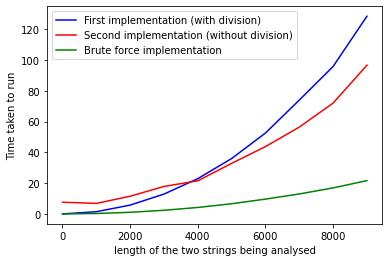

In [88]:
import matplotlib.pyplot as plt
x_values = list(range(4,10000,1000))
plt.xlabel('length of the two strings being analysed')
plt.ylabel('Time taken to run')
plt.plot(x_values,y_first, color = 'blue', label = 'First implementation (with division)')
plt.plot(x_values,y_second, color = 'red', label = 'Second implementation (without division)')
plt.plot(x_values,y_brute, color = 'green', label = 'Brute force implementation')
plt.legend()

In order to test for the time complexity and comparing across the runtime for the different algorithms being used, the following plot we created to experimentally show the relationship across the different input variables.

From the first plot which increases the lengths of the two strings being analysed while keeping the k constant show us that each iteration of the algorithm according to an increase in the lengths of the two strings and what we can find out about the relationship between the length of the strings being used in the algorithm and the implementations.

From the three plots, it becomes easily evident that the best solution is just the brute force pythonic solution that is within python itself's implementation of how it stores data. This makes sense because in any case, python itself stores data within the RAM of the computer in a manner that is easily accessible and so, even though it has to compare across each and every substring, it will always have a lower real world runtime than the others because even though they are able to technically look up the hashed values at a constant time complexity, this doesn't accurately portray information about the amount of time that the algorithms take to create the hash tables in the first place. This is because to add values to each and every point in the hash table, you need to find the hashed value for all the substrings which turns out to cost O(mn) by itself in the first place.

Another thing that we see from the plot is that after a certain point, the second implementation starts to take less time than the first to calculate the plagiarism points. This tells us that in order to gain the computational advantage of not having to go through a high expected average load with a lot of collisions as in the first implementation is only gained after a high enough length for both strings. 

Arithmetically, what this means is that the high initial computational cost of the construction of the huge hash table within the second implementation will take a lot of time compared to the first implementation. But the growth rate (constant factor c) that is associated with both of these O(mn) time complexity functions is much lower for the second implementation allowing it to be faster after a certain length.

In all cases however, in real life, it would always be better to use the brute force implementation because finding the construction of the two hash tables would take much longer time with the same time complexity as the brute force implementation which negatively balances out the advantage gained from accessing the hashed values directly.

One case in which it might be better would be to have a constant comparison being done with a template paper/text since the high initial cost associated with the second implementation can be done earlier allowing for easy comparisons done much faster with all the hashed values already being in memory.


Number of collisions = 0
The amount of plagiarism is 100.09980039920158 percent
Number of collisions = 0
The amount of plagiarism is 90.11976047904191 percent
Number of collisions = 0
The amount of plagiarism is 80.13972055888223 percent
Number of collisions = 0
The amount of plagiarism is 70.15968063872255 percent
Number of collisions = 0
The amount of plagiarism is 60.17964071856288 percent
Number of collisions = 0
The amount of plagiarism is 50.199600798403196 percent
Number of collisions = 0
The amount of plagiarism is 40.21956087824351 percent
Number of collisions = 0
The amount of plagiarism is 30.239520958083833 percent
Number of collisions = 0
The amount of plagiarism is 20.25948103792415 percent
Number of collisions = 0
The amount of plagiarism is 10.27944111776447 percent


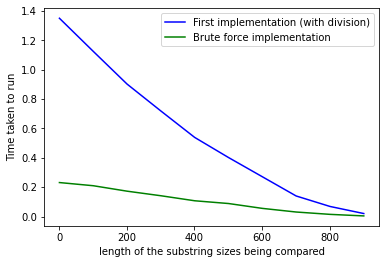

In [94]:
import matplotlib.pyplot
import timeit

x_values = list(range(1,1000,100))

y_first_k = []
y_brute_k = []

for i in range(1,1000,100):
    
    text1 = example_creator(1001)
    text2 = example_creator(1001)
    current_k = i
    
    start = timeit.default_timer()
    
    rh_get_match(text1,text2,current_k)
    
    stop = timeit.default_timer()
    
    y_first_k.append(stop-start)
    
    start = timeit.default_timer()
    
    bruteforce(text1,text2,current_k)
    
    stop = timeit.default_timer()   
    y_brute_k.append(stop-start)
    
plt.xlabel('length of the substring sizes being compared')
plt.ylabel('Time taken to run')
plt.plot(x_values,y_first_k, color = 'blue', label = 'First implementation (with division)')
plt.plot(x_values,y_brute_k, color = 'green', label = 'Brute force implementation')
plt.legend()

In [107]:
#Random paragraph generated through https://randomwordgenerator.com/paragraph.php

text1 = '''
It was easy to spot her. All you needed to do was look at her socks. They were never a matching pair. One would be green while the other would be blue. One would reach her knee while the other barely touched her ankle. Every other part of her was perfect, but never the socks. They were her micro act of rebellion. I'm so confused by your ridiculous meltdown that I must insist on some sort of explanation for your behavior towards me. It just doesn't make any sense. There's no way that I deserved the treatment you gave me without an explanation or an apology for how out of line you have been. Patricia's friend who was here hardly had any issues at all, but she wasn't telling the truth. Yesterday, before she left to go home, she heard that her husband is in the hospital and pretended to be surprised. It later came out that she was the person who had put him there. Turning away from the ledge, he started slowly down the mountain, deciding that he would, that very night, satisfy his curiosity about the man-house. In the meantime, he would go down into the canyon and get a cool drink, after which he would visit some berry patches just over the ridge, and explore among the foothills a bit before his nap-time, which always came just after the sun had walked past the middle of the sky. At that period of the day the sun’s warm rays seemed to cast a sleepy spell over the silent mountainside, so all of the animals, with one accord, had decided it should be the hour for their mid-day sleep.'''

Another thing that we're able to see is that the time complexity for the first and brute force implementation with regards to the length-k of the substrings being analyzed with the plot above. This tells us that there is an inverse relationship between the two.

This makes sense conceptually as well since a higher k for the same full string would mean a fewer number of substrings in total that need to be compared with each other. This gives us a better hint into the actual running time of the three algorithms which would be (from construction to required result)


O(nm/k) where n and m are the length of the strings whereas k is the length of the substrings being analyzed between the two strings.

More specifically, It would be O(nm/k) + O(m/k)*load-factor for the first and second algorithms where O(nm/k) is the cost associated with constructing the required hash tables and O(m/k)*load-factor for querying and comparing one's substring values with the others. Here, the load-factor would be the average amount of values present at every hash which would increase with size of the strings within the first implementation but stay constant within the second implementation since we're looking to only store the unique hash values for each substring.
For the bruteforce implementation, the time complexity would just be O(nm/k) on the basis of the number of comparisons with respect to the number of substrings being taken.

Expanding upon the helpful nature of the hash structure, we see that after an initial high computational cost associated with the construction of the hash tables, the actual strength of those data structures lie in being able to utilize the constant time calling functionality which we saw within the implementations of the algorithms designed above. In comparison, we saw that with the simple datastructure of list in python which stores string variables, the creation takes almost no time at all which allows for extremely high efficiency comparisons to be made across different lists for the presence of one substring. This tells us that for this specific problem, it's better to use an easier more pythonic implementation in the form of the brute force solution with the use of the lists in python even with its seemingly ugly polynomial time complexity with regards to searching. Because even though searches take O(1) in hash tables, having to calculate all of those O(1)s with creating the hash table is enough to dissipate all the advantage one might gain from the constant searches.

Number of collisions = 7430
Number of collisions = 6234
Number of collisions = 5211
Number of collisions = 4013
Number of collisions = 3206
Number of collisions = 2372
Number of collisions = 1790
Number of collisions = 1215
Number of collisions = 744
Number of collisions = 426


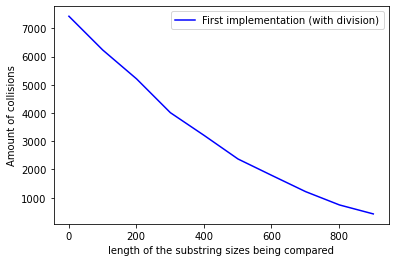

In [111]:
import matplotlib.pyplot
import timeit

x_values = list(range(1,1000,100))

y_first_collisions = []



for i in range(10,1000,100):
    
    
    current_k = i
    
    
    x = preprocessing(text1)
    a = Hash_table_rolling(x,current_k)
    a.set_up_table()
    a.return_collisions()
    
    
    y_first_collisions.append(a.return_collisions())
    
    
plt.xlabel('length of the substring sizes being compared')
plt.ylabel('Amount of collisions')
plt.plot(x_values,y_first_collisions, color = 'blue', label = 'First implementation (with division)')
plt.legend()




Number of collisions = 0
Number of collisions = 49
Number of collisions = 206
Number of collisions = 443
Number of collisions = 790
Number of collisions = 1271
Number of collisions = 1829
Number of collisions = 2514
Number of collisions = 3290
Number of collisions = 4203
Number of collisions = 5198
Number of collisions = 6283


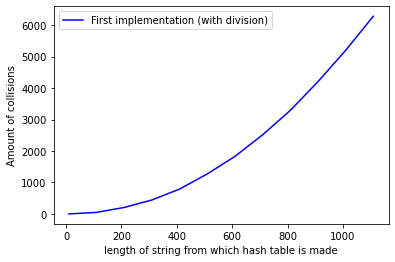

In [110]:
import matplotlib.pyplot
import timeit

x_values = list(range(10,len(x),100))

y_first_collisions = []

x = preprocessing(text1)


for i in range(10,len(x),100):
    
    
    current_k = 5
    
    
    a = Hash_table_rolling(x[:i],current_k)
    a.set_up_table()
    a.return_collisions()
    
    
    y_first_collisions.append(a.return_collisions())
    
    
plt.xlabel('length of string from which hash table is made')
plt.ylabel('Amount of collisions')
plt.plot(x_values,y_first_collisions, color = 'blue', label = 'First implementation (with division)')
plt.legend()

Furthermore, for another proof of why the first implementation's complexity evolves as it does, we need to look no further than the number of collisions that form as a result of both larger strings with respect to constructing the required hash tables and alongside, the length of the k-substrings being analyzed. We see with the plots above that the number of collisions grows exponentially with the length of a "random" string with which the hash table is being constructed. Alongside, it is inversely proportional to k length of the substrings being analysed. This makes sense since we expect greater collisions overall with the more amount of data being stored in the small hash table. This tells us that within our limited hash table as was constructed with the first implementation, we incrementally get a lot of collisions with higher input sizes which results in a higher average load size at each hash value which in turn contributes proportionally to the time complexity of the total amount of time required to compute the plagiarised portions between the two texts.

LOs:

\#ComputationalComplexity: I give an in-depth analysis of all algorithms constructed within the paper while identifying which ones would work best within a real-world context. This analysis is furthered with the use of experimental evidence in the form of the plots which show the scaling behaviors of the functions as had been calculated theoretically beforehand. Furthermore, there is evident analysis of space complexity as well and how that contributes to the construction of the second completely unique alphabetical implementation of the hash table where one needs to have enough space to store all the k-length substrings completely.

\#Datastructures: Not only did I effectively utilize the required and appropriate data structures within the context of the assignment (hash tables) but I provided a deep interpretation of the workings of the data structure within my object oriented implementation and the time complexity associated with each of the functionality that it provides within the context. Furthermore, I effectively compare it to the barebones solution offered with the bruteforce solution in the form of comparing across python lists and effectively critique the use of hash function and tables and analyse the scenarios in which they would be better to use alongside highlighting how within the general use case, the bruteforce solution would always be better.

\#ComplexityAnalysis: I do appropriate asymptotic notation within the context of the hash tables used for the solutions with respect to the time complexity alongside providing evidence in the form of plots that showcase the expected theoretical behavior showing a well-justified analysis.


HCs:

\#dataviz – I make use of effective and highly detailed plots labeled correctly with the legends showcasing each iteration of the algorithm. These easy-to-understand visualizations are highly accurate and effective within the context and serve as perfect evidence to augment my reasoning regarding the time complexity and space complexity of the different algorithms used within the context.

\#critique - I effectively select and critique the computational complexity of the algorithms being used within the context and provide detailed explanations of the contexts in which they would be applicable while providing ample justification for why I'm using the arguments that I am in the evaluation of the algorithms. This is shown with the highly detailed descriptions of the contexts in which each of the algorithms would fare better than the other.

\#studyreplication - Within the context of computational reasoning and group effort, I effectively utilize the standards of codereadibility alongside providing ample test cases for why my algorithms work to solve the problems. This is especially necessary within coworking computational contexts where there would be a need to produce code that is easily understandable and replicable by colleagues to solve similar problems within the context. Thus, by making my implementaion robust, I allow others to use the same concepts to get to the same results within the context of the algorithms being used with hashing and its time complexity.